In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc


rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.max_columns = None  # 길어서 생략된 열 다 보이게 하기

In [3]:
distribution_centers = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/distribution_centers_optimized.parquet')
# events_file = pd.read_parquet('../dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized.parquet')
inventory_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/inventory_items_optimized.parquet')
orders = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/orders_optimized.parquet')
order_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')
products = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/products_optimized.parquet')
users = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/users_optimized.parquet') 
events1 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided1.parquet")
events2 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided2.parquet")
events = pd.concat([events1, events2]).sort_index()

In [4]:
all_order_data = order_items.merge(orders, on=['order_id', 'user_id'], how='left').merge(products, on=['product_id']).merge(users, on='user_id')
all_order_data

,order_item_id,order_id,user_id,product_id,inventory_item_id,status_x,created_at_x,shipped_at_x,delivered_at_x,returned_at_x,sale_price,status_y,gender_x,created_at_y,returned_at_y,shipped_at_y,delivered_at_y,num_of_item,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,first_name,last_name,email,age,gender_y,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Kathryn,Ortega,kathrynortega@example.net,29,F,Hebei,3863 Johnson Brooks Suite 474,74199,Jinhua,China,39.388173,115.731465,Search,2021-11-27 07:33:00+00:00
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Terri,Alvarez,terrialvarez@example.net,35,F,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Rebecca,Mcgee,rebeccamcgee@example.org,49,F,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Shelly,Rogers,shellyrogers@example.net,44,F,Hyogo,6970 Cherry Extension Apt. 442,675-0137,Kakogawa City,Japan,34.718505,134.825010,Search,2022-05-17 00:17:00+00:00
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Mariah,Stephens,mariahstephens@example.com,59,F,England,6522 Stephens Meadows Suite 475,LA1,Lancaster,United Kingdom,54.045973,-2.794106,Search,2021-06-23 17:21:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,Returned,M,2020-12-23 00:07:00+00:00,2020-12-30 22:43:00+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,1,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,Joseph,Carpenter,josephcarpenter@example.org,23,M,Ningxia Hui Autonomous Region,110 Morris Walk Suite 190,750000,Shenzhen,China,38.507578,106.315768,Search,2020-01-16 00:07:00+00:00
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,Shipped,M,2022-01-10 03:11:00+00:00,NaT,2022-01-10 03:42:00+00:00,NaT,3,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,Adam,Vasquez,adamvasquez@example.net,55,M,Seoul,77740 Linda Drive Apt. 783,156-090,Seoul,South Korea,37.485807,126.972360,Display,2019-12-10 03:11:00+00:00
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:3

In [5]:
cancelled_orders = all_order_data[all_order_data['status_x'] == 'Cancelled'].copy()
returned_orders = all_order_data[all_order_data['status_x'] == 'Returned'].copy()
complete_orders = all_order_data[all_order_data['status_x'].isin(['Complete', 'Shipped'])].copy()

In [6]:
print(f"브랜드 수 :", all_order_data['brand'].nunique())
print(f"제품 id 수 :", all_order_data['product_id'].nunique())
print(f"카테고리 수 :", all_order_data['category'].nunique())

브랜드 수 : 2752
제품 id 수 : 29046
카테고리 수 : 26


In [7]:
all_order_data

,order_item_id,order_id,user_id,product_id,inventory_item_id,status_x,created_at_x,shipped_at_x,delivered_at_x,returned_at_x,sale_price,status_y,gender_x,created_at_y,returned_at_y,shipped_at_y,delivered_at_y,num_of_item,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,first_name,last_name,email,age,gender_y,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,NaT,NaT,NaT,1,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Kathryn,Ortega,kathrynortega@example.net,29,F,Hebei,3863 Johnson Brooks Suite 474,74199,Jinhua,China,39.388173,115.731465,Search,2021-11-27 07:33:00+00:00
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,Complete,F,2023-03-14 03:59:00+00:00,NaT,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,1,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Terri,Alvarez,terrialvarez@example.net,35,F,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,Complete,F,2023-12-03 13:23:00+00:00,NaT,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,4,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Rebecca,Mcgee,rebeccamcgee@example.org,49,F,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,Shipped,F,2023-12-23 00:17:00+00:00,NaT,2023-12-24 16:44:00+00:00,NaT,4,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Shelly,Rogers,shellyrogers@example.net,44,F,Hyogo,6970 Cherry Extension Apt. 442,675-0137,Kakogawa City,Japan,34.718505,134.825010,Search,2022-05-17 00:17:00+00:00
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,Shipped,F,2022-06-17 17:21:00+00:00,NaT,2022-06-19 19:29:00+00:00,NaT,3,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,Mariah,Stephens,mariahstephens@example.com,59,F,England,6522 Stephens Meadows Suite 475,LA1,Lancaster,United Kingdom,54.045973,-2.794106,Search,2021-06-23 17:21:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,Returned,M,2020-12-23 00:07:00+00:00,2020-12-30 22:43:00+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,1,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,Joseph,Carpenter,josephcarpenter@example.org,23,M,Ningxia Hui Autonomous Region,110 Morris Walk Suite 190,750000,Shenzhen,China,38.507578,106.315768,Search,2020-01-16 00:07:00+00:00
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,Shipped,M,2022-01-10 03:11:00+00:00,NaT,2022-01-10 03:42:00+00:00,NaT,3,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,Adam,Vasquez,adamvasquez@example.net,55,M,Seoul,77740 Linda Drive Apt. 783,156-090,Seoul,South Korea,37.485807,126.972360,Display,2019-12-10 03:11:00+00:00
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:3

In [8]:
order_items

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02
...,...,...,...,...,...,...,...,...,...,...,...
181754,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00


In [9]:
products

,product_id,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1
...,...,...,...,...,...,...,...,...,...
29115,5676,12.42338,Pants & Capris,WHAT GOES AROUND COMES AROUND Women's Colette ...,What Goes Around Comes Around,24.17,Women,3A01FC0853EBEBA94FDE4D1CC6FB842A,10
29116,6538,13.67500,Shorts,WHAT GOES AROUND COMES AROUND Women's Mimi Shorts,What Goes Around Comes Around,25.00,Women,741A0099C9AC04C7BFC822CAF7C7459F,10
29117,6712,12.40000,Shorts,WHAT GOES AROUND COMES AROUND Women's Fifi Short,What Goes Around Comes Around,25.00,Women,5726DAF2C9EE0F955ECA58291C26D2F3,10
29118,6821,13.47500,Shorts,WHAT GOES AROUND COMES AROUND Women's Ferguson...,What Goes Around Comes Around,25.00,Women,BA0A4D6ECEA3E9E126DD3B6D77291C97,10


In [10]:
orders_merged = pd.merge(order_items, products, on ='product_id', how='left')

orders_merged['profit'] = orders_merged['sale_price'] - orders_merged['cost']

# date 컬럼 포멧
orders_merged[['created_at', 'shipped_at', 'delivered_at']] =\
orders_merged[['created_at', 'shipped_at', 'delivered_at']].apply(lambda col: pd.to_datetime(col, errors='coerce', format='mixed'))
orders_merged

# processing, shipped 까지 complete로 넣음
orders_complete_merged = orders_merged.loc[
    (orders_merged['status'] == 'Complete') |
    (orders_merged['status'] =='Processing') |
    (orders_merged['status'] =='Shipped')
].copy()
orders_complete_merged

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,profit
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700
5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181753,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,516.483001
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,594.404999
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,516.483001
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,594.404999


In [11]:
orders_complete_merged['year'] = orders_complete_merged['created_at'].dt.year
orders_complete_merged['month'] = orders_complete_merged['created_at'].dt.month
orders_complete_merged_202311 = orders_complete_merged[orders_complete_merged['created_at'] < '2023-12-01']
orders_complete_merged_202311.created_at.max()

Timestamp('2023-11-30 23:58:54+0000', tz='UTC')

# 총 매출, 비용, 수익, 마진율

In [12]:
def calcaulate_summary(orders_complete_merged):
    total_revenue = round(orders_complete_merged_202311['sale_price'].sum(), 2)
    total_cost = round(orders_complete_merged_202311['cost'].sum(), 2)
    total_profit = round(orders_complete_merged_202311['profit'].sum(), 2)
    total_margin_rate = ((total_revenue - total_cost) / total_cost) * 100

    summary_df = pd.DataFrame({
        'total_revenue': [total_revenue],
        'total_cost': [total_cost],
        'total_profit': [total_profit],
        'total_margin_rate': [total_margin_rate]
    })
    return summary_df

summary_df = calcaulate_summary(orders_complete_merged_202311)
summary_df

,total_revenue,total_cost,total_profit,total_margin_rate
0,6964919.3,3351457.27,3613462.03,107.817637


# 브랜드 / 카테고리 / 제품id 매출액 순위 및 전체 매출 기여도

## 브랜드 별 수익-매출-비용

In [13]:
brand_performance = orders_complete_merged_202311.groupby('brand')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_performers = brand_performance.sort_values(by='sale_price', ascending=False).head(10)

print(top_performers)

                  brand        profit     sale_price          cost
447        Calvin Klein  71200.593016  134029.800375  62829.207359
701              Diesel  64535.006284  129846.719887  65311.713603
29    7 For All Mankind  57714.975280  120723.980347  63009.005067
465            Carhartt  62908.554428  118334.069280  55425.514852
2490      True Religion  55017.251473  115815.799781  60798.548308
2447     Tommy Hilfiger  44425.894743   81303.070101  36877.175357
2399     The North Face  38665.117421   70800.290085  32135.172664
2587             Volcom  32782.812165   67093.099858  34310.287693
1943         Quiksilver  30607.939887   66506.440066  35898.500179
567            Columbia  35950.614550   65971.449807  30020.835257


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/3419111909.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_performance = orders_complete_merged_202311.groupby('brand')[['profit', 'sale_price', 'cost']].sum().reset_index()


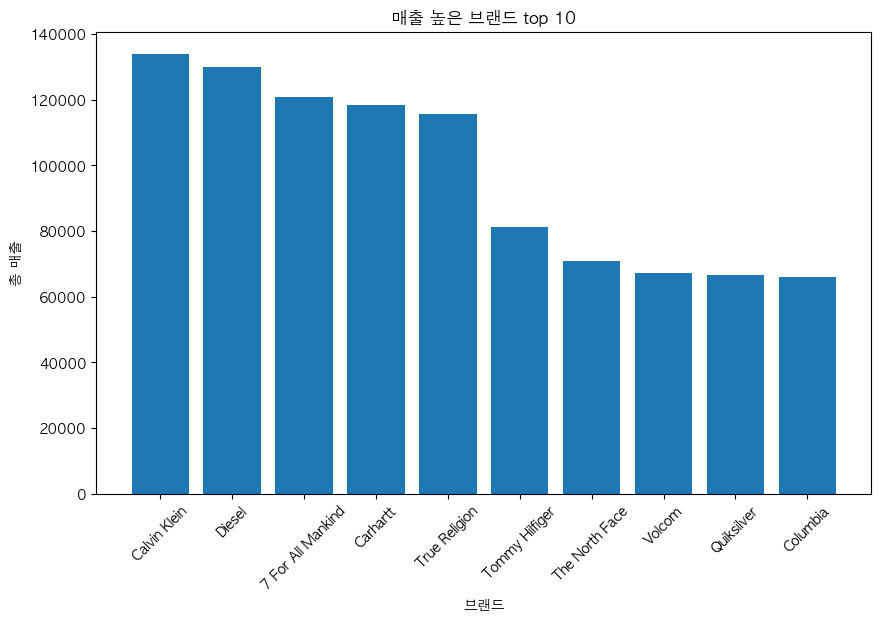

In [14]:
# top performers 시각화

plt.figure(figsize=(10,6))
plt.bar(top_performers['brand'], top_performers['sale_price'])
plt.xlabel('브랜드')
plt.ylabel('총 매출')
plt.xticks(rotation=45)
plt.title('매출 높은 브랜드 top 10')
plt.show()

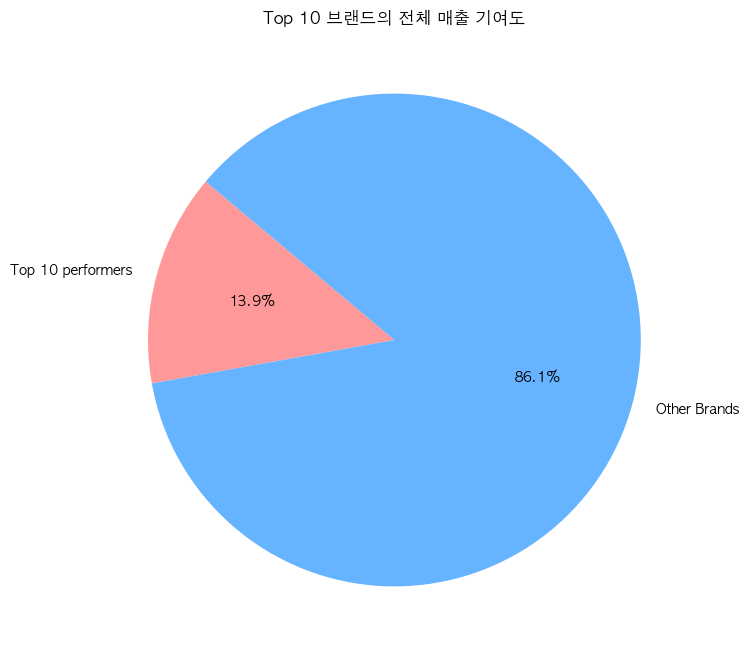

In [15]:
total_top_performers_profit = top_performers['sale_price'].sum()

top_performers_brands = top_performers['brand'].tolist()
other_company_profits = orders_complete_merged_202311.loc[~orders_complete_merged_202311['brand'].isin(top_performers_brands), 'sale_price'].sum()
combined_top_performers = pd.DataFrame({'brand':['Top 10 performers', 'Other Brands'], 'sales' : [total_top_performers_profit, other_company_profits]})


# 시각화
labels = combined_top_performers['brand']
sizes = combined_top_performers['sales']

colors = ['#ff9999','#66b3ff']

# 파이 차트 생성
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 브랜드의 전체 매출 기여도')
plt.show()


## 카테고리 별 수익-매출-비용

In [16]:
category_performance = orders_complete_merged_202311.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_cat_performers = category_performance.sort_values(by='sale_price', ascending=False).head()

print(top_cat_performers)

                         category         profit     sale_price           cost
11              Outerwear & Coats  465557.840936  838461.459509  372903.618573
7                           Jeans  377749.629966  812945.741300  435196.111334
22                       Sweaters  279876.332772  539733.620129  259857.287356
21            Suits & Sport Coats  251808.058194  421061.279623  169253.221429
5   Fashion Hoodies & Sweatshirts  200649.867416  418197.470337  217547.602921


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2734173617.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_performance = orders_complete_merged_202311.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()


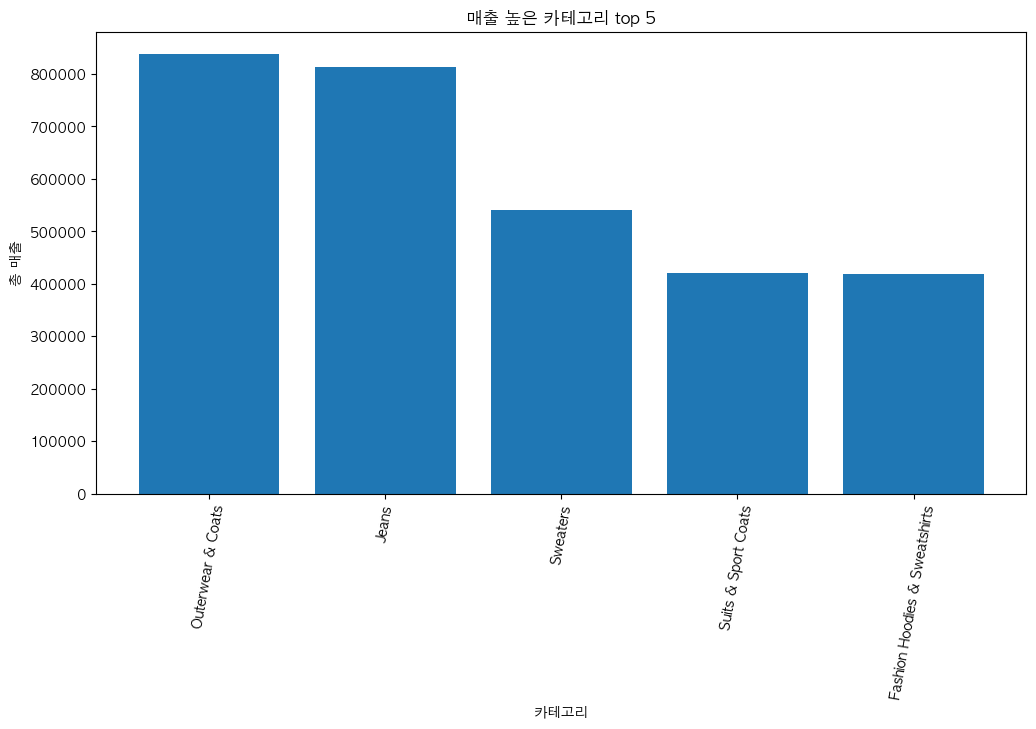

In [17]:
# top_cat_performers 시각화 

plt.figure(figsize=(12,6))
plt.bar(top_cat_performers['category'], top_cat_performers['sale_price'])
plt.xlabel('카테고리')
plt.ylabel('총 매출')
plt.xticks(rotation=80)
plt.title('매출 높은 카테고리 top 5')
plt.show()

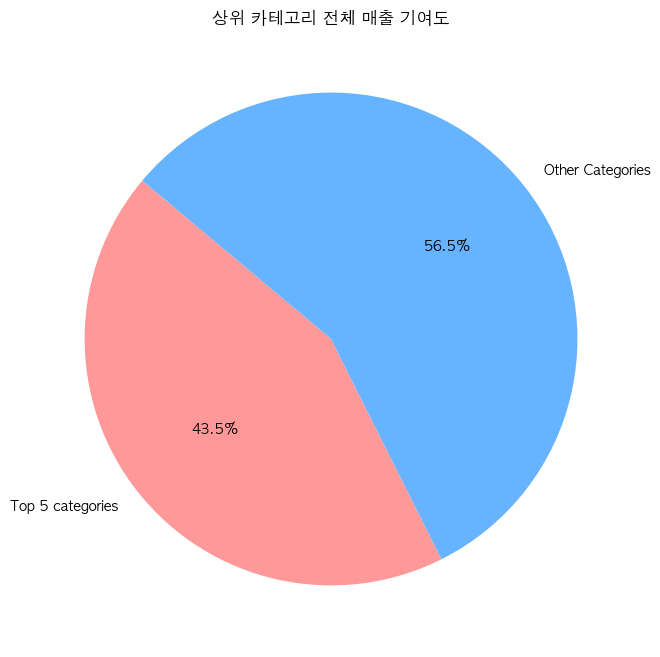

In [18]:
total_top_category_performance = top_cat_performers['sale_price'].sum()

top_cat_performers_list = top_cat_performers['category'].tolist()
other_cat_performance = orders_complete_merged_202311.loc[~orders_complete_merged_202311['category'].isin(top_cat_performers_list), 'sale_price'].sum()
combined_top_cat_performers = pd.DataFrame({'category': ['Top 5 categories', 'Other Categories'], 'sales': [total_top_category_performance, other_cat_performance]})


# 시각화
labels = combined_top_cat_performers['category']
sizes = combined_top_cat_performers['sales']

colors = ['#ff9999','#66b3ff']

# 파이 차트 생성
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('상위 카테고리 전체 매출 기여도')
plt.show()


In [19]:
orders_complete_merged_202311.groupby('category')['product_id'].nunique().sort_values(ascending=False)

## top 5 카테고리의 매출이 높을 수 밖에 없는 이유 중 하나로, 카테고리 내 상품수가 많음
### 예외. 가장 상품을 많이 보유한 intimates 는 매출 top 10에 안들음 

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/54731974.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_complete_merged_202311.groupby('category')['product_id'].nunique().sort_values(ascending=False)


category
Intimates                        2295
Jeans                            1966
Tops & Tees                      1837
Fashion Hoodies & Sweatshirts    1829
Swim                             1766
Sleep & Lounge                   1747
Shorts                           1730
Sweaters                         1710
Accessories                      1541
Active                           1405
Outerwear & Coats                1397
Underwear                        1074
Pants                            1032
Dresses                           922
Socks                             897
Maternity                         887
Plus                              740
Suits & Sport Coats               729
Socks & Hosiery                   650
Pants & Capris                    601
Blazers & Jackets                 550
Leggings                          547
Skirts                            350
Suits                             188
Jumpsuits & Rompers               153
Clothing Sets                      36
Nam

In [20]:
orders_complete_merged[orders_complete_merged['category']=='Intimates']

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,profit,year,month
31,35882,24703,19697,12536,96821,Complete,2023-11-23 04:34:36+00:00,2023-11-23 09:20:00+00:00,2023-11-24 03:24:00+00:00,NaT,1.75,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,0.73675,2023,11
32,112748,77696,62002,12536,304194,Complete,2024-01-17 03:54:46.754527+00:00,2024-01-15 10:04:24.754527+00:00,2024-01-19 05:05:24.754527+00:00,NaT,1.75,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,0.73675,2024,1
33,117438,80895,64513,12536,316927,Processing,2023-11-04 05:25:47+00:00,NaT,NaT,NaT,1.75,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,0.73675,2023,11
34,166143,114444,91424,12536,448518,Processing,2021-11-19 13:59:16+00:00,NaT,NaT,NaT,1.75,1.01325,Intimates,Individual Bra Extenders,Extenders,1.75,Women,359499F804EA7988921BF86C9377FB95,4,0.73675,2021,11
180,22591,15634,12504,12265,60963,Complete,2020-12-31 01:09:44+00:00,2020-12-31 17:17:00+00:00,2021-01-04 06:13:00+00:00,NaT,2.99,1.62357,Intimates,Alivila.Y Fashion Sexy Lace & Sheer Net Linger...,Alivila.Y Fashion,2.99,Women,2B3E69A7084C76E56BE15598FC72DED6,1,1.36643,2020,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181617,81244,55905,44773,10453,219250,Complete,2022-10-08 05:28:26+00:00,2022-10-08 14:48:00+00:00,2022-10-10 18:18:00+00:00,NaT,903.00,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,390.99900,2022,10
181628,135711,93409,74506,10453,366366,Complete,2023-07-04 02:56:16+00:00,2023-07-04 11:08:00+00:00,2023-07-07 04:41:00+00:00,NaT,903.00,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,390.99900,2023,7
181637,180571,124384,99342,10453,487550,Complete,2023-08-04 07:18:00+00:00,2023-08-05 10:41:00+00:00,2023-08-10 05:21:00+00:00,NaT,903.00,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,390.99900,2023,8
181664,169722,116895,93371,10453,458228,Processing,2023-08-30 07:41:12+00:00,NaT,NaT,NaT,903.00,512.00100,Intimates,NIKE WOMEN'S PRO COMPRESSION SPORTS BRA *Outst...,Nike,903.00,Women,4801441F041958AFACA324C43C40787B,7,390.99900,2023,8


In [21]:
product_count_per_category_brand = orders_complete_merged_202311.groupby(['category', 'brand'])['product_id'].nunique()
product_count_per_category_brand = product_count_per_category_brand[product_count_per_category_brand != 0]
product_count_per_category_brand

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2110780950.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_count_per_category_brand = orders_complete_merged_202311.groupby(['category', 'brand'])['product_id'].nunique()


category     brand                  
Accessories  106Shades                   5
             180s                       15
             A:X Armani Exchange         2
             ALL BLACK                   1
             AN1225                      2
                                        ..
Underwear    Wolverine                   6
             Wrangler                    2
             YogaColors                  2
             Zimmerli of Switzerland     2
             bioworld                    3
Name: product_id, Length: 5797, dtype: int64

## 매출 높은 상위 브랜드들의 카테고리 속 비중 확인

In [22]:
# 매출이 높은 상위 브랜드들의 카테고리 속 비중 구하기
top_performers_brands = top_performers['brand'].tolist()

# 매출이 높은 상위 브랜드들의 매출
top_performers_sales = brand_performance[brand_performance['brand'].isin(top_performers_brands)]['sale_price'].sum()

# 카테고리별 매출
category_sales = orders_complete_merged_202311.groupby('category')['sale_price'].sum()

# 상위 브랜드들이 속한 카테고리의 비중 계산
category_sales_top_brands = orders_complete_merged_202311[orders_complete_merged_202311['brand'].isin(top_performers_brands)].groupby('category')['sale_price'].sum()

# 카테고리별 매출 중 매출이 높은 상위 브랜드들의 비중
category_sales_top_brands_ratio = (category_sales_top_brands / category_sales).sort_values(ascending=False).reset_index(name='ratio')

print(category_sales_top_brands_ratio)

                         category     ratio
0                           Jeans  0.339000
1               Outerwear & Coats  0.248554
2                          Shorts  0.184398
3                       Underwear  0.170325
4             Suits & Sport Coats  0.150651
5                     Tops & Tees  0.146675
6   Fashion Hoodies & Sweatshirts  0.127443
7                          Active  0.123420
8                           Pants  0.115716
9                            Swim  0.112919
10                       Sweaters  0.095509
11                 Pants & Capris  0.085573
12                          Socks  0.048398
13                    Accessories  0.046432
14                        Dresses  0.042972
15                         Skirts  0.036627
16                           Plus  0.036563
17                  Clothing Sets  0.034535
18                 Sleep & Lounge  0.034292
19                       Leggings  0.028849
20              Blazers & Jackets  0.026997
21                Socks & Hosier

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/3001935074.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = orders_complete_merged_202311.groupby('category')['sale_price'].sum()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/3001935074.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales_top_brands = orders_complete_merged_202311[orders_complete_merged_202311['brand'].isin(top_performers_brands)].groupby('category')['sale_price'].sum()


In [23]:
# 매출이 높은 상위 브랜드들의 카테고리 속 비중 구하기
top_performers_brands = top_performers['brand'].tolist()

# 매출이 높은 상위 브랜드들의 매출
top_performers_sales = brand_performance[brand_performance['brand'].isin(top_performers_brands)]['sale_price'].sum()

# 카테고리별 매출
category_sales = orders_complete_merged_202311.groupby('category')['sale_price'].sum()

# 상위 브랜드들이 속한 카테고리의 비중 계산
category_sales_top_brands = orders_complete_merged_202311[orders_complete_merged_202311['brand'].isin(top_performers_brands)].groupby(['category', 'brand'])['sale_price'].sum().reset_index()

# 카테고리별 매출 중 매출이 높은 상위 브랜드들의 비중
category_sales_top_brands_ratio = pd.merge(category_sales_top_brands, category_sales.reset_index(), on='category', suffixes=('_brand', '_category'))
category_sales_top_brands_ratio['ratio'] = category_sales_top_brands_ratio['sale_price_brand'] / category_sales_top_brands_ratio['sale_price_category']
category_sales_top_brands_ratio = category_sales_top_brands_ratio.sort_values(by='ratio', ascending=False)
category_sales_top_brands_ratio


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/903376601.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = orders_complete_merged_202311.groupby('category')['sale_price'].sum()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/903376601.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales_top_brands = orders_complete_merged_202311[orders_complete_merged_202311['brand'].isin(top_performers_brands)].groupby(['category', 'brand'])['sale_price'].sum().reset_index()


,category,brand,sale_price_brand,sale_price_category,ratio
19321,Jeans,7 For All Mankind,100349.670319,812945.741300,0.123440
69347,Underwear,Calvin Klein,12753.750025,130906.070188,0.097427
21782,Jeans,True Religion,78920.460136,812945.741300,0.097080
19993,Jeans,Diesel,73733.859879,812945.741300,0.090700
30781,Outerwear & Coats,Carhartt,63470.659363,838461.459509,0.075699
...,...,...,...,...,...
23912,Jumpsuits & Rompers,Pepsi,0.000000,26181.930104,0.000000
23913,Jumpsuits & Rompers,Perry,0.000000,26181.930104,0.000000
23914,Jumpsuits & Rompers,Perry Ellis,0.000000,26181.930104,0.000000
23915,Jumpsuits & Rompers,Persol,0.000000,26181.930104,0.000000


In [24]:
# 데이터프레임에서 상위 브랜드들의 비중이 0인 행 제외
filtered_df = category_sales_top_brands_ratio[category_sales_top_brands_ratio['ratio'] > 0]

# for category, group in filtered_df.groupby('category'):
#     plt.figure(figsize=(8, 6))
#     plt.pie(group['ratio'], labels=group['brand'], autopct='%1.1f%%', startangle=140)
#     plt.title(f'{category} Category Sales Ratio of Top Brands')
#     plt.axis('equal')  # 원 그래프를 원형으로 유지
#     plt.show()

### 필터링 안된 범위에서 비율 구하는 건 실패함... 

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/3559661064.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (category, data) in enumerate(filtered_df.groupby('category')):


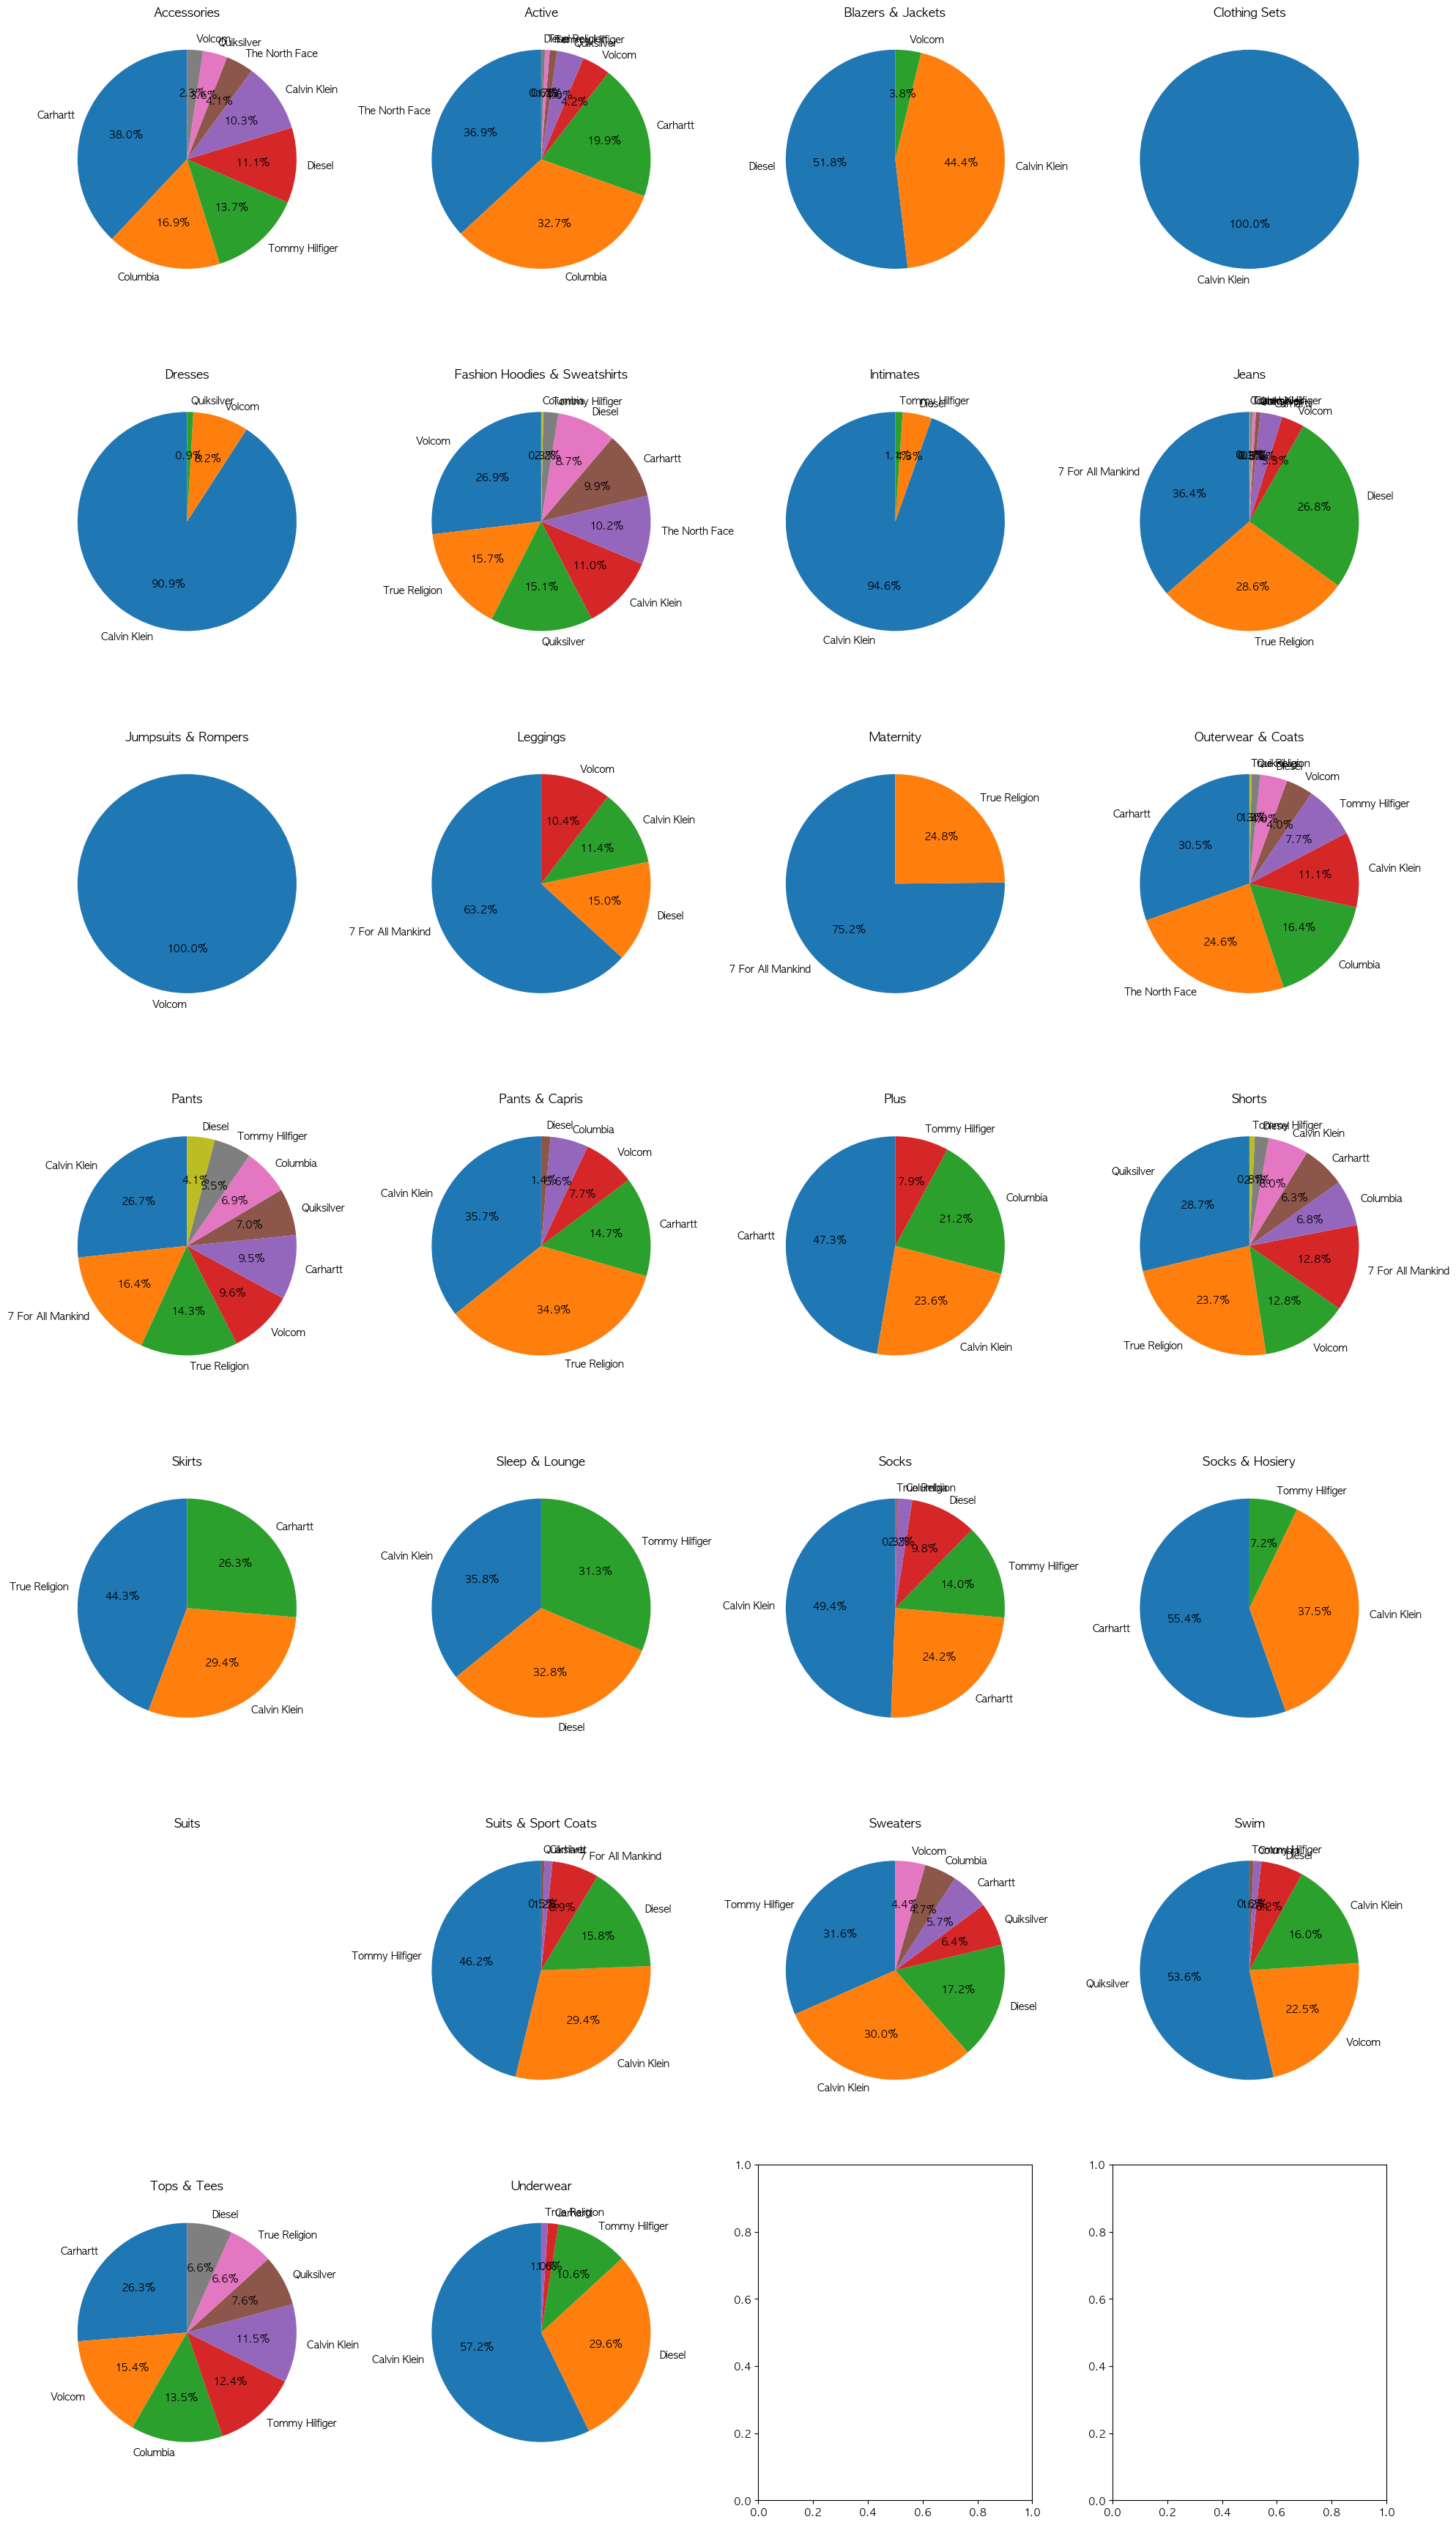

In [25]:

# 카테고리별 원그래프 subplot 그리기
num_categories = len(filtered_df['category'].unique())
num_rows = (num_categories + 3) // 4  # 올림 계산

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))

for i, (category, data) in enumerate(filtered_df.groupby('category')):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.pie(data['ratio'], labels=data['brand'], autopct='%1.1f%%', startangle=90)
    ax.set_title(category)

plt.tight_layout()
plt.show()

# 전체 카테고리 내 브랜드 비율  ->> 실패
# num_categories = len(category_sales_top_brands_ratio['category'].unique())
# num_rows = (num_categories + 3) // 4  # 올림 계산

# fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5*num_rows))

# for i, (category, data) in enumerate(category_sales_top_brands_ratio.groupby('category')):
#     row = i // 4
#     col = i % 4
#     ax = axes[row, col]
#     ax.pie(data['ratio'].fillna(0), labels=data['brand'], autopct='%1.1f%%', startangle=90)
#     ax.pie(data['ratio'], labels=data['brand'], autopct=lambda x: f'{x:.1f}%' if x > 0 else '', startangle=90)
#     ax.set_title(category)

# plt.tight_layout()
# plt.show()


In [26]:
# # Define a custom autopct function to adjust label positions
# def autopct_format(values):
#     def my_autopct(pct):
#         total = sum(values)
#         val = int(round(pct*total/100))
#         return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
#     return my_autopct

# # 카테고리별 원그래프 subplot 그리기
# num_categories = len(filtered_df['category'].unique())
# num_cols = min(num_categories, 3)
# num_rows = (num_categories + 2) // 3  # 올림 계산

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15*num_cols, 5*num_rows))

# for i, (category, data) in enumerate(filtered_df.groupby('category')):
#     ax = axes[i // num_cols, i % num_cols]
#     ax.pie(data['ratio'], labels=data['brand'], autopct=autopct_format(data['ratio']), startangle=90)
#     ax.set_title(category)

# plt.tight_layout()
# plt.show()


In [27]:
# # 카테고리별 원그래프 subplot 그리기
# num_categories = len(filtered_df['category'].unique())
# num_cols = min(num_categories, 3)
# num_rows = (num_categories + 2) // 3  # 올림 계산

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15*num_cols, 5*num_rows))

# for i, (category, data) in enumerate(filtered_df.groupby('category')):
#     ax = axes[i // num_cols, i % num_cols]
#     ax.pie(data['ratio'], labels=data['brand'], startangle=90)

#     # annotation을 사용하여 텍스트 배치
#     total = data['ratio'].sum()
#     ypos = 0
#     for j, (brand, ratio) in enumerate(zip(data['brand'], data['ratio'])):
#         angle = 360 * (ypos + ratio / 2) / total
#         ax.annotate('{:.1f}%'.format(ratio), xy=(0, 0), xytext=(1.3, ypos), textcoords='data', ha='center', va='center', fontsize=10)
#         ypos += ratio

#     ax.set_title(category)

# plt.tight_layout()
# plt.show()


## 카테고리 - 제품이름 별 주문수량

In [28]:
popular_products = orders_complete_merged_202311.groupby(['category', 'product_name'])['order_id'].count().reset_index()
popular_products_except_jeans = orders_complete_merged_202311.query("category != 'Jeans'").groupby(['category', 'product_name'])['order_id'].count().reset_index()
top_20_products = popular_products.sort_values(by='order_id', ascending=False).head(20)
top_20_products_ex_jeans = popular_products_except_jeans.sort_values(by='order_id', ascending=False).head(20)

top_20_products

## 청바지 제외하고도 확인 !!!! 

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2949608118.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popular_products = orders_complete_merged_202311.groupby(['category', 'product_name'])['order_id'].count().reset_index()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2949608118.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popular_products_except_jeans = orders_complete_merged_202311.query("category != 'Jeans'").groupby(['category', 'product_name'])['order_id'].count().reset_index()


,category,product_name,order_id
213938,Jeans,Wrangler Men's Premium Performance Cowboy Cut ...,44
188254,Jeans,7 For All Mankind Men's Standard Classic Strai...,25
201516,Jeans,Kenneth Cole Men's Straight Leg Jean,23
211961,Jeans,True Religion Men's Ricky Straight Jean,23
466852,Sleep & Lounge,HUGO BOSS Men's Long Pant,22
203107,Jeans,Lucky Brand Mens Men's 361 Vintage Straight De...,21
213937,Jeans,Wrangler Men's Original Cowboy Cut Relaxed Fit...,21
502711,Socks,Puma Men's Socks,20
417416,Shorts,Lilly Pulitzer Women's Callahan Short,19
285136,Maternity,Motherhood Maternity: 3 Pack Maternity Bikini ...,19


In [29]:
# Jeans 필터링(제외)
top_20_products_except_jeans = top_20_products.query("category != 'Jeans'")
top_20_products_except_jeans

,category,product_name,order_id
466852,Sleep & Lounge,HUGO BOSS Men's Long Pant,22
502711,Socks,Puma Men's Socks,20
417416,Shorts,Lilly Pulitzer Women's Callahan Short,19
285136,Maternity,Motherhood Maternity: 3 Pack Maternity Bikini ...,19
428549,Shorts,Wrangler Men's Genuine Tampa Cargo Short,19
687209,Underwear,Michael Kors Men's 3 Pack Brief,19
674600,Underwear,Bjorn Borg Men's Side Stetch Solid Boxer Brief,19
478808,Sleep & Lounge,State O Maine Big and Tall Plaid Microfleece L...,18
663338,Tops & Tees,Polo Ralph Lauren Classic-Fit Mesh Polo,18
158580,Fashion Hoodies & Sweatshirts,UltraClub Adult Sherpa-Lined Full-Zip Fleece w...,17


In [30]:
# top_10_products 시각화..?

In [31]:
orders_complete_merged.columns

Index(['order_item_id', 'order_id', 'user_id', 'product_id',
       'inventory_item_id', 'status', 'created_at', 'shipped_at',
       'delivered_at', 'returned_at', 'sale_price', 'cost', 'category',
       'product_name', 'brand', 'retail_price', 'department', 'sku',
       'distribution_center_id', 'profit', 'year', 'month'],
      dtype='object')

# 연도별 매출-비용-수익 추이

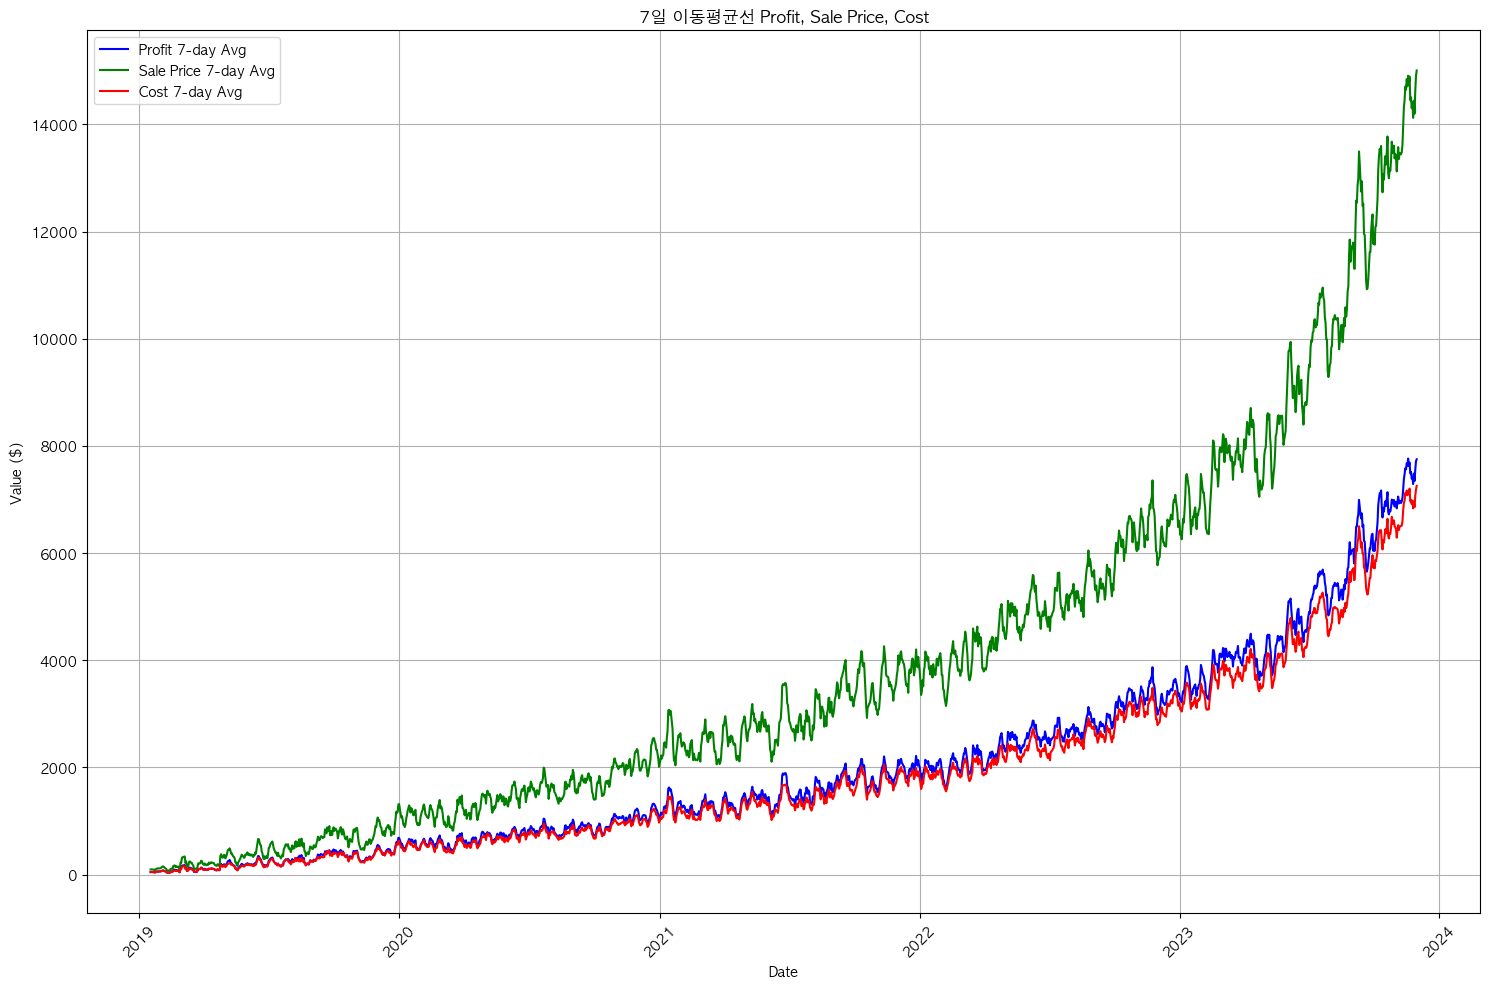

In [32]:
# 연도별 그룹핑
grouped_by_year = orders_complete_merged_202311.groupby(orders_complete_merged_202311['created_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()


plt.figure(figsize=(15, 10))

for column in ['profit', 'sale_price', 'cost']:
    grouped_by_year[column+'_7day_avg'] = grouped_by_year[column].rolling(window=7).mean()
grouped_by_year = grouped_by_year.dropna()

# profit
plt.plot(grouped_by_year['created_at'], grouped_by_year['profit_7day_avg'], label='Profit 7-day Avg', color='blue')

# sale price
plt.plot(grouped_by_year['created_at'], grouped_by_year['sale_price_7day_avg'], label='Sale Price 7-day Avg', color='green')

# cost
plt.plot(grouped_by_year['created_at'], grouped_by_year['cost_7day_avg'], label='Cost 7-day Avg', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.title('7일 이동평균선 Profit, Sale Price, Cost')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# top 카테고리의 연도별 매출액 추이

In [33]:
# target_category = 'Outerwear & Coats'
# t1 = orders_complete_merged[orders_complete_merged['category'] == target_category]

# # 연도별 그룹핑
# grouped_by_year_t1 = t1.groupby(orders_complete_merged['created_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()


# grouped_by_year_t1['sale_price_7day_avg'] = grouped_by_year_t1['sale_price'].rolling(window=7).mean()
# grouped_by_year = grouped_by_year.dropna()


# plt.figure(figsize=(15, 10))
# plt.plot(grouped_by_year_t1['created_at'], grouped_by_year_t1['sale_price_7day_avg'], label='Sale Price 7-day Avg', color='green')
# # Adding labels and title
# plt.xlabel('Date')
# plt.ylabel('Value ($)')
# plt.title('7일 이동평균선 Profit, Sale Price, Cost')
# plt.legend()
# # Displaying the plot
# plt.grid(True)
# plt.tight_layout()
# plt.show()


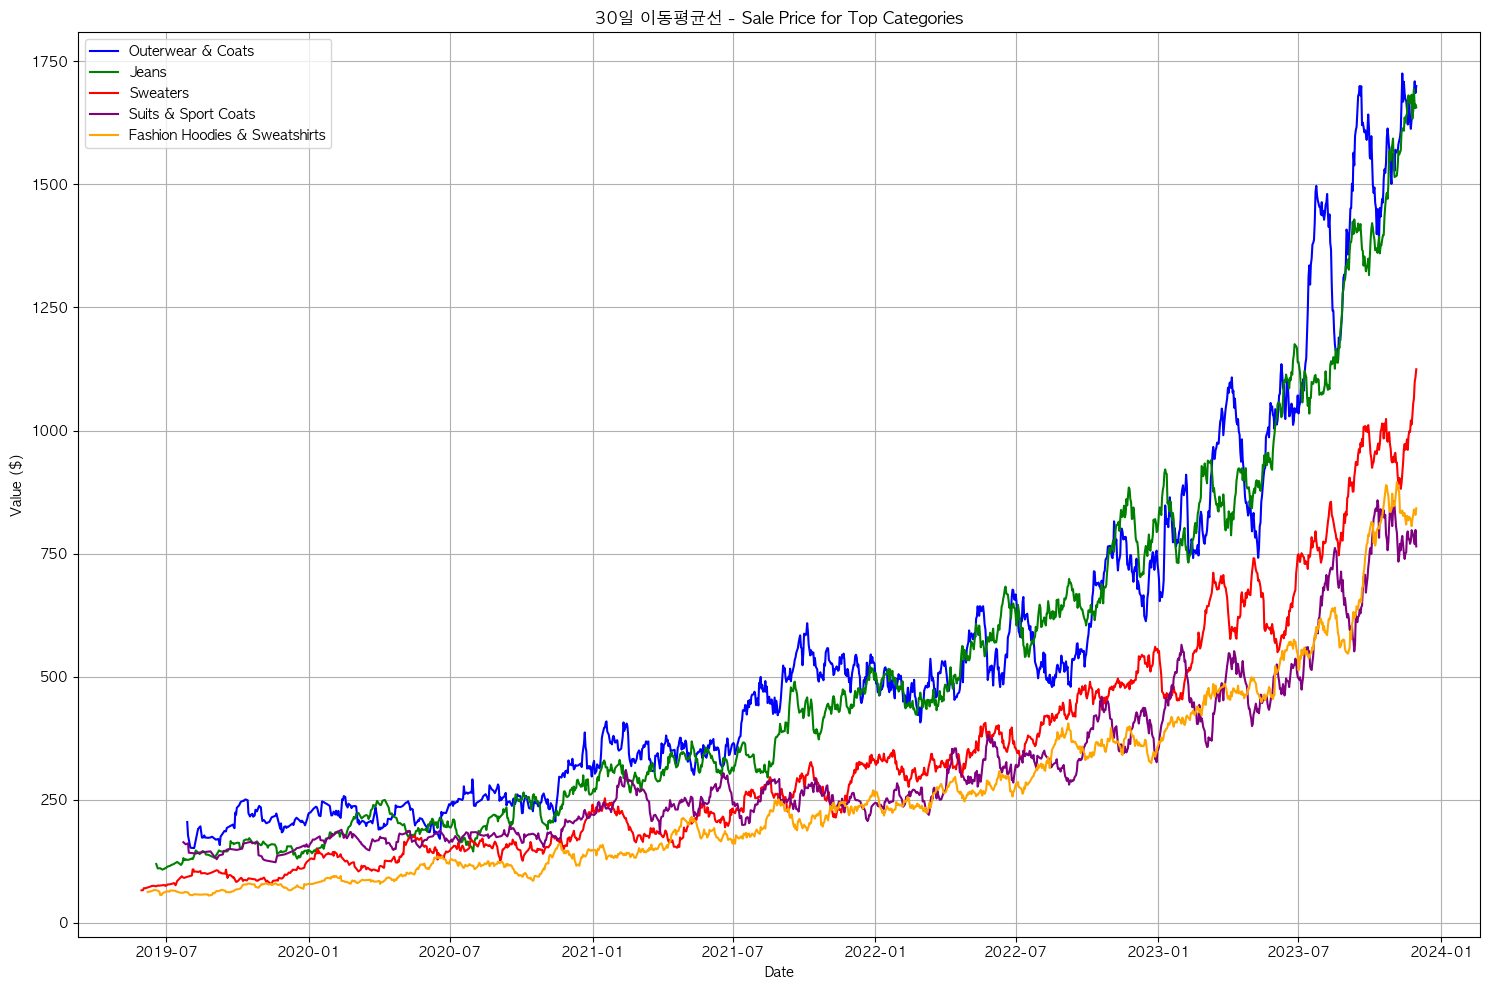

In [34]:
# 색깔 리스트
colors = ['blue', 'green', 'red', 'purple', 'orange']

# 새로운 figure 생성
plt.figure(figsize=(15, 10))

# top_cat_performers 리스트의 각 카테고리에 대해 반복하여 그래프를 그림
for i, target_category in enumerate(top_cat_performers_list):
    t1 = orders_complete_merged_202311[orders_complete_merged_202311['category'] == target_category]

    # 연도별 그룹핑
    grouped_by_year_t1 = t1.groupby(orders_complete_merged_202311['created_at'].dt.date)[['profit', 'sale_price', 'cost']].sum().reset_index()

    # 7일 이동평균 계산
    grouped_by_year_t1['sale_price_7day_avg'] = grouped_by_year_t1['sale_price'].rolling(window=30).mean()
    grouped_by_year_t1 = grouped_by_year_t1.dropna()

    # 그래프 그리기
    plt.plot(grouped_by_year_t1['created_at'], grouped_by_year_t1['sale_price_7day_avg'], label=target_category, color=colors[i])

# 축 레이블과 제목 추가
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.title('30일 이동평균선 - Sale Price for Top Categories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 전년 대비 매출 상승률

## 전체 카테고리

In [35]:
growth_rate = orders_complete_merged_202311.groupby('year')[['sale_price']].sum().reset_index()

growth_rate['sales_growth_rate'] = growth_rate['sale_price'].pct_change()*100

growth_rate

,year,sale_price,sales_growth_rate
0,2019,1.651741e+05,NaN
1,2020,5.621470e+05,240.336007
2,2021,1.090479e+06,93.984737
3,2022,1.867970e+06,71.298022
4,2023,3.279149e+06,75.546195


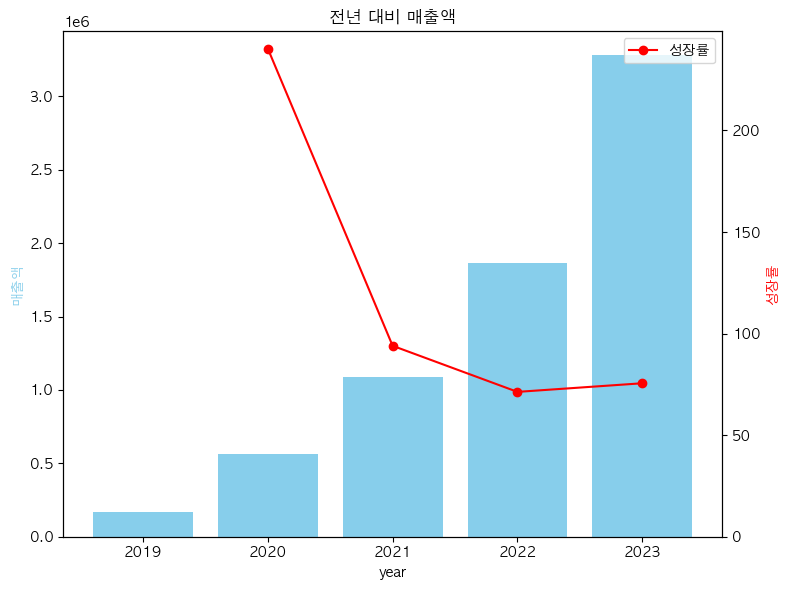

In [36]:
# 서브플롯 생성
fig, ax1 = plt.subplots(figsize=(8, 6))

# 매출액 막대 그래프
ax1.bar(growth_rate['year'], growth_rate['sale_price'], color='skyblue')
ax1.set_xlabel('year')
ax1.set_ylabel('매출액', color='skyblue')
ax1.set_title('전년 대비 매출액')
ax1.tick_params(axis='y')

# 성장률 선 그래프
ax2 = ax1.twinx()
ax2.plot(growth_rate['year'], growth_rate['sales_growth_rate'], marker='o', color='red')
ax2.set_ylabel('성장률', color='red')
ax2.set_ylim(0, None)  # 성장률은 음수가 될 수 없으므로 y축의 최소값을 0으로 설정
ax2.legend(['성장률'], loc='upper right')

# for i, v in enumerate(growth_rate['sales_growth_rate']):
#     ax2.text(i, v + 0.02, str(round(v,2)), ha='center', va='bottom')

# fig.suptitle('전년 대비 매출액 및 성장률', fontsize=16)
fig.tight_layout()
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()

## 매출 Top6 category 연도별 매출액 및 매출 상승률

In [37]:
category_performance2 = orders_complete_merged_202311.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()
top_cat_performers2 = category_performance2.sort_values(by='sale_price', ascending=False).head(6)
top_cat_performers2

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2845308071.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_performance2 = orders_complete_merged_202311.groupby('category')[['profit', 'sale_price', 'cost']].sum().reset_index()


,category,profit,sale_price,cost
11,Outerwear & Coats,465557.840936,838461.459509,372903.618573
7,Jeans,377749.629966,812945.741300,435196.111334
22,Sweaters,279876.332772,539733.620129,259857.287356
21,Suits & Sport Coats,251808.058194,421061.279623,169253.221429
5,Fashion Hoodies & Sweatshirts,200649.867416,418197.470337,217547.602921
23,Swim,204537.069516,418049.070469,213512.000953


In [38]:
category_performance_limit = orders_complete_merged_202311.groupby(['year','category'])[['profit', 'sale_price', 'cost']].sum().reset_index()
top_cat_performers_by_year = category_performance_limit.groupby('year').apply(lambda x: x.nlargest(6, 'sale_price')).reset_index(drop=True)

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/1203405785.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_performance_limit = orders_complete_merged_202311.groupby(['year','category'])[['profit', 'sale_price', 'cost']].sum().reset_index()
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/1203405785.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cat_performers_by_year = category_performance_limit.groupby('year').apply(lambda x: x.nlargest(6, 'sale_price')).

In [39]:
category_performance_limit

,year,category,profit,sale_price,cost
0,2019,Accessories,3225.733130,5399.480002,2173.746872
1,2019,Active,3517.963356,6032.170012,2514.206656
2,2019,Blazers & Jackets,1941.384725,3138.590007,1197.205282
3,2019,Clothing Sets,108.484882,295.990002,187.505120
4,2019,Dresses,2824.062308,5184.510009,2360.447701
...,...,...,...,...,...
125,2023,Suits & Sport Coats,117157.430194,195777.439765,78620.009571
126,2023,Sweaters,131383.023888,253315.610080,121932.586192
127,2023,Swim,95368.998458,195500.690177,100131.691719
128,2023,Tops & Tees,64593.227402,146744.940491,82151.713089


In [40]:
top_cat_performers_by_year

,year,category,profit,sale_price,cost
0,2019,Outerwear & Coats,12827.797146,23132.520031,10304.722885
1,2019,Jeans,8197.820002,17798.290016,9600.470014
2,2019,Sweaters,6729.488042,12912.849979,6183.361937
3,2019,Suits & Sport Coats,6640.168996,11136.550001,4496.381005
4,2019,Swim,4815.688584,9980.420015,5164.731432
5,2019,Fashion Hoodies & Sweatshirts,4616.816957,9392.119987,4775.303029
6,2020,Jeans,29050.382870,62493.170040,33442.787170
7,2020,Outerwear & Coats,34495.613539,62078.239941,27582.626402
8,2020,Sweaters,22680.042919,43779.379996,21099.337077
9,2020,Suits & Sport Coats,20853.808619,35075.540013,14221.731395


In [41]:
top_6_category = ['Outerwear & Coats', 'Jeans', 'Sweaters', 'Suits & Sport Coats', 'Fashion Hoodies & Sweatshirts', 'Swim']

In [42]:
# 하나만 뽑는 그래프 코드만 남겨둠

# fashionhoodie = top_cat_performers_by_year[top_cat_performers_by_year['category']=='Fashion Hoodies & Sweatshirts']
# fashionhoodie['sales_growth_rate'] = fashionhoodie['sale_price'].pct_change()*100

# fig, ax1 = plt.subplots(figsize=(8, 6))

# # 매출액 막대 그래프
# ax1.bar(fashionhoodie['year'], fashionhoodie['sale_price'], color='skyblue')
# ax1.set_xlabel('year')
# ax1.set_ylabel('매출액', color='skyblue')
# ax1.set_title('Fashion Hoodies & Sweatshirts 매출 증가율')
# ax1.tick_params(axis='y')

# # 성장률 선 그래프
# ax2 = ax1.twinx()
# ax2.plot(fashionhoodie['year'], fashionhoodie['sales_growth_rate'], marker='o', color='red')
# ax2.set_ylabel('성장률', color='red')
# ax2.set_ylim(0, None)  # 성장률은 음수가 될 수 없으므로 y축의 최소값을 0으로 설정
# ax2.legend(['성장률'], loc='upper right')
# fig.tight_layout()
# plt.xticks(rotation=45)  
# plt.show()

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2315048570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['sales_growth_rate'] = category_data['sale_price'].pct_change() * 100
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2315048570.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['sales_growth_rate'] = category_data['sale_price'].pct_change() * 100
/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_1367/2315048570.py:7: SettingWi

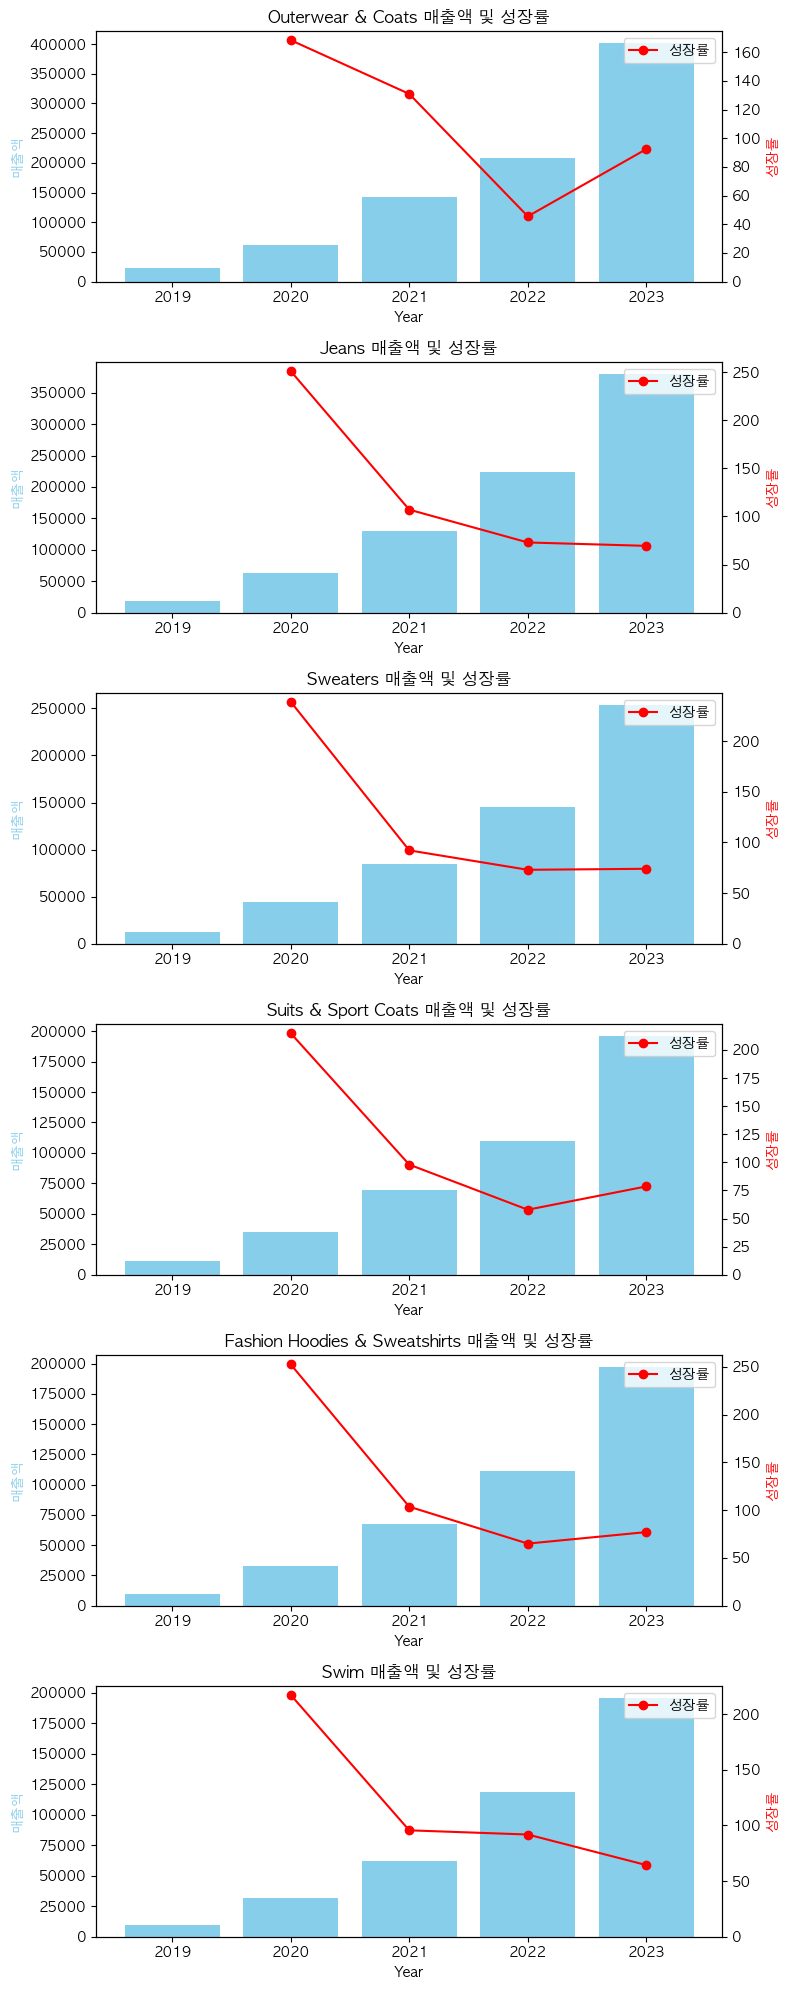

In [43]:
top_6_categories = ['Outerwear & Coats', 'Jeans', 'Sweaters', 'Suits & Sport Coats', 'Fashion Hoodies & Sweatshirts', 'Swim']

fig, axes = plt.subplots(nrows=len(top_6_categories), figsize=(8, 20))

for i, category in enumerate(top_6_categories):
    category_data = category_performance_limit[category_performance_limit['category'] == category]
    category_data['sales_growth_rate'] = category_data['sale_price'].pct_change() * 100
    
    ax1 = axes[i]
    # 매출액 막대 그래프
    ax1.bar(category_data['year'], category_data['sale_price'], color='skyblue')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('매출액', color='skyblue')
    ax1.set_title(f'{category} 매출액 및 성장률')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    # 성장률 선 그래프
    ax2.plot(category_data['year'], category_data['sales_growth_rate'], marker='o', color='red')
    ax2.set_ylabel('성장률', color='red')
    ax2.set_ylim(0, None)
    ax2.legend(['성장률'], loc='upper right')

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [44]:
clv = pd.read_csv('/Users/hj/Documents/Four-A/khj/data/order_items_merge_clv.csv', index_col=0)
clv

,id,order_id_x,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,recency,frequancy,monetary,cluster,G,K,S,M,Q,J,CLV
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaN,NaN,NaN,0.02,42,3,2.209753,1,2.209753,6.629259,0.157840,2.427662,0.736584,8.259327,20.420425
4,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaN,0.02,262,1,0.020000,1,0.020000,0.020000,0.000076,0.000000,0.020000,0.111367,0.171443
7,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaN,0.02,460,1,188.950001,2,188.950001,188.950001,0.410761,0.000000,188.950001,1158.495250,1725.756013
13,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaN,NaN,0.02,411,2,25.061875,1,25.061875,50.123749,0.121956,17.371568,12.530937,150.837228,256.047313
17,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaN,NaN,0.02,73,1,45.240001,1,45.240001,45.240001,0.619726,0.000000,45.240001,194.100390,330.440120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142938,30972,21384,17056,15486,83467,Shipped,2023-08-09 14:42:39+00:00,2023-08-10 10:46:00+00:00,NaN,NaN,903.00,114,1,903.000000,4,903.000000,903.000000,7.921053,0.000000,903.000000,4276.787199,6993.708252
142939,86895,59774,47747,15486,234510,Shipped,2023-07-29 09:57:25+00:00,2023-08-01 08:17:00+00:00,NaN,NaN,903.00,125,1,903.000000,4,903.000000,903.000000,7.224000,0.000000,903.000000,4359.967305,7076.191305
142940,87069,59904,47864,8429,234990,Shipped,2023-07-09 05:15:14+00:00,2023-07-10 16:49:00+00:00,NaN,NaN,903.00,145,1,903.000000,4,903.000000,903.000000,6.227586,0.000000,903.000000,4493.990569,7209.218156
142941,113283,78064,62277,8398,305663,Shipped,2023-08-22 10:06:35+00:00,2023-08-25 08:17:00+00:00,NaN,NaN,903.00,101,1,903.000000,4,903.000000,903.000000,8.940594,0.000000,903.000000,4167.453827,6885.394421


In [45]:
orders_complete_merged_202311

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,profit,year,month
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700,2023,3
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700,2022,6
5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700,2023,9
6,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46+00:00,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,0.312620,2021,10
7,116116,80002,63821,14159,313368,Complete,2022-04-01 13:25:52+00:00,2022-03-31 05:13:00+00:00,2022-04-02 22:18:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,0.312620,2022,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181753,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,516.483001,2023,10
181755,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,594.404999,2022,1
181756,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,999.00,Men,C1AA157F9E8516370E3345F226EF62FC,5,516.483001,2023,2
181757,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,999.00,Men,1CE5E897CDA6AEB211DFFE8D514F4365,5,594.404999,2023,11


In [46]:
clv.cluster.value_counts()

cluster
1    36660
0    14132
2     5978
3     1537
4      157
Name: count, dtype: int64

In [47]:
clv.describe()

,id,order_id_x,user_id,product_id,inventory_item_id,sale_price,recency,frequancy,monetary,cluster,G,K,S,M,Q,J,CLV
count,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000,58464.000000
mean,90771.945950,62505.496220,49923.944239,15688.734230,245000.005850,38.362931,414.070830,1.383039,63.565151,0.921165,63.565151,66.308507,1.009353,1.831413,62.273418,353.885024,548.872866
std,52494.221836,36143.078864,28844.590332,8477.723095,141728.754325,45.877552,376.026451,0.680967,86.404086,0.683442,86.404086,85.062027,6.895255,4.095450,87.164780,500.955335,752.440919
min,1.000000,1.000000,1.000000,1.000000,3.000000,0.020000,1.000000,1.000000,0.020000,0.000000,0.020000,0.020000,0.000076,0.000000,0.020000,0.000000,0.171443
25%,45288.750000,31166.750000,24954.500000,8894.750000,122167.250000,14.990000,112.000000,1.000000,11.807969,1.000000,11.807969,16.990000,0.051509,0.000000,7.491094,58.737572,103.966274
50%,90710.500000,62406.500000,49889.500000,15960.500000,244815.000000,25.000000,300.000000,1.000000,33.990002,1.000000,33.990002,36.990002,0.138195,0.000000,33.000000,178.452753,286.525128
75%,136248.000000,93795.500000,74825.250000,23611.250000,367781.750000,44.000000,619.000000,2.000000,79.989998,1.000000,79.989998,80.760001,0.423530,1.949476,79.989998,443.137610,688.126436
max,181758.000000,125225.000000,100000.000000,29120.000000,490703.000000,999.000000,1789.000000,4.000000,1341.489998,4.000000,1341.489998,1341.489998,495.000000,56.147521,1341.489998,7473.900697,10994.905825


In [48]:
clv.groupby('cluster').agg({
    'recency' : ['mean', 'min', 'max'],
    'frequancy' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max'],
    'CLV' : ['mean', 'min', 'max', 'count']
})

recency           frequancy            monetary              \
               mean min   max      mean min max        mean         min   
cluster                                                                   
0        494.509836   2  1778  1.004175   1   2   85.078939   39.500000   
1        351.853082   1  1783  1.609247   1   4   20.380797    0.020000   
2        546.682670   3  1789  1.000000   1   1  184.518986  106.870003   
3        622.959662  10  1769  1.000000   1   1  348.767996  218.810003   
4        607.210191  35  1734  1.000000   1   1  813.162420  509.990005   

                              CLV                                    
                 max         mean          min           max  count  
cluster                                                              
0         467.500000   722.957109   410.737658   2071.934578  14132  
1         495.000000   168.926283     0.171443   1980.000000  36660  
2         695.000000  1621.613553  1102.671481   3536.693268   5978  
3        1054.980000  3149.659680  2275.511886   6201.800032   1537  
4        1341.489998  7290.465603  5111.284878  10994.905825    157

In [49]:
users.user_id.unique()

<IntegerArray>
[  457,  6578, 36280, 60193, 64231, 72187, 22528, 34417, 50098, 63352,
 ...
 82576, 97115, 17254, 92296, 96127, 93247, 59110, 57045, 73312, 77764]
Length: 100000, dtype: Int32

In [50]:
users

,user_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
0,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2022-07-19 13:51:00+00:00
1,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2023-11-08 18:49:00+00:00
2,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Email,2019-08-24 06:10:00+00:00
3,60193,Jimmy,Conner,jimmyconner@example.com,64,M,Acre,0966 Jose Branch Apt. 008,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-02-15 11:26:00+00:00
4,64231,Natasha,Wilson,natashawilson@example.net,25,F,Acre,20798 Phillip Trail Apt. 392,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-03-13 06:45:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,93247,Crystal,Williams,crystalwilliams@example.com,36,F,Île-de-France,984 Brady Branch,77120,Beautheil-Saints,France,48.789740,3.095796,Search,2021-02-13 01:36:00+00:00
99996,59110,Daniel,Griffin,danielgriffin@example.org,12,M,Île-de-France,89560 Phillips Lakes Apt. 604,77160,Chenoise-Cucharmoy,France,48.589783,3.243343,Organic,2022-09-01 12:01:00+00:00
99997,57045,Olivia,Wiley,oliviawiley@example.org,53,F,Île-de-France,749 Ronald Forge,77320,Choisy-en-Brie,France,48.763993,3.319993,Search,2021-06-19 11:39:00+00:00
99998,73312,Emily,Bird,emilybird@example.org,16,F,Île-de-France,78117 Anderson Oval,77320,Choisy-en-Brie,France,48.763993,3.319993,Search,2023-08-08 16:24:00+00:00


(array([3327., 1702., 1673., 1681., 1767., 1751., 3386., 1754., 1657.,
        1647., 1701., 1693., 3271., 1780., 1625., 1687., 1624., 1663.,
        3460., 1724., 1687., 1697., 1662., 1656., 1695., 3444., 1644.,
        1730., 1706., 1674., 1655., 3340., 1727., 1722., 1675., 1715.,
        1668., 3533., 1656., 1730., 1742., 1679., 1631., 3398., 1706.,
        1724., 1697., 1732., 1646., 3456.]),
 array([12.  , 13.16, 14.32, 15.48, 16.64, 17.8 , 18.96, 20.12, 21.28,
        22.44, 23.6 , 24.76, 25.92, 27.08, 28.24, 29.4 , 30.56, 31.72,
        32.88, 34.04, 35.2 , 36.36, 37.52, 38.68, 39.84, 41.  , 42.16,
        43.32, 44.48, 45.64, 46.8 , 47.96, 49.12, 50.28, 51.44, 52.6 ,
        53.76, 54.92, 56.08, 57.24, 58.4 , 59.56, 60.72, 61.88, 63.04,
        64.2 , 65.36, 66.52, 67.68, 68.84, 70.  ]),
 <BarContainer object of 50 artists>)

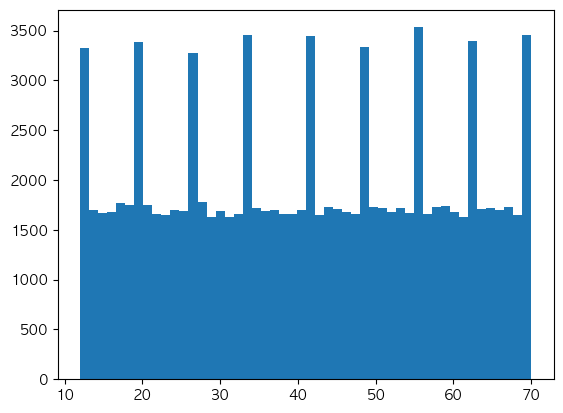

In [51]:
plt.hist(users['age'],bins=50)

In [52]:
orders_complete_merged_202311.category.value_counts()

category
Intimates                        8623
Jeans                            8206
Tops & Tees                      7699
Fashion Hoodies & Sweatshirts    7626
Swim                             7381
Sweaters                         7189
Sleep & Lounge                   7186
Shorts                           7109
Accessories                      6320
Active                           5829
Outerwear & Coats                5748
Underwear                        4834
Pants                            4712
Socks                            4096
Dresses                          3530
Maternity                        3326
Suits & Sport Coats              3309
Plus                             2800
Socks & Hosiery                  2442
Pants & Capris                   2171
Leggings                         2072
Blazers & Jackets                2071
Skirts                           1382
Suits                             648
Jumpsuits & Rompers               592
Clothing Sets                     138
Nam

In [53]:
orders_complete_merged_202311[orders_complete_merged_202311['category']=='Accessories']

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id,profit,year,month
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.020000,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.020000,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700,2023,3
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.020000,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.020000,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700,2022,6
5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.020000,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.020000,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.011700,2023,9
6,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46+00:00,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,0.490000,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.490000,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,0.312620,2021,10
7,116116,80002,63821,14159,313368,Complete,2022-04-01 13:25:52+00:00,2022-03-31 05:13:00+00:00,2022-04-02 22:18:00+00:00,NaT,0.490000,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.490000,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,0.312620,2022,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179701,94980,65325,52168,13758,256373,Shipped,2023-06-05 00:27:57+00:00,2023-06-03 06:29:00+00:00,NaT,NaT,297.950012,112.327154,Accessories,Tom Ford Marko FT0144 Sunglasses - 18V Shiny R...,Tom Ford,297.950012,Women,5FD28170BD0B91D09F02AE9983BC67E6,3,185.622858,2023,6
179776,23626,16347,13040,14329,63748,Complete,2021-03-12 13:10:36+00:00,2021-03-12 16:52:00+00:00,2021-03-15 02:35:00+00:00,NaT,299.000000,115.413999,Accessories,Maui Jim Mavericks Sunglasses,Maui Jim,299.000000,Women,33192F6B62911C61D4073EF0F9923420,8,183.586001,2021,3
179792,52746,36261,29062,14329,142301,Processing,2022-10-13 07:32:31+00:00,NaT,NaT,NaT,299.000000,115.413999,Accessories,Maui Jim Mavericks Sunglasses,Maui Jim,299.000000,Women,33192F6B62911C61D4073EF0F9923420,8,183.586001,2022,10
179814,147292,101421,80955,14329,397644,Shipped,2021-07-09 10:10:06+00:00,2021-07-11 22:11:00+00:00,NaT,NaT,299.000000,115.413999,Accessories,Maui Jim Mavericks Sunglasses,Maui Jim,299.000000,Women,33192F6B62911C61D4073EF0F9923420,8,183.586001,2021,7


In [54]:
order_items.sort_values('order_id')

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
22628,1,1,1,2953,3,Shipped,2022-07-20 10:32:05+00:00,2022-07-20 16:42:00+00:00,NaT,NaT,15.000000
163080,2,1,1,4731,7,Shipped,2022-07-20 11:05:38+00:00,2022-07-20 16:42:00+00:00,NaT,NaT,125.000000
35284,3,1,1,7656,9,Shipped,2022-07-19 11:29:28+00:00,2022-07-20 16:42:00+00:00,NaT,NaT,19.990000
39779,4,2,2,25774,11,Complete,2022-02-20 10:28:57+00:00,2022-02-22 12:23:00+00:00,2022-02-23 18:29:00+00:00,NaT,22.000000
125364,5,3,3,22308,13,Processing,2023-04-23 09:04:57+00:00,NaT,NaT,NaT,59.990002
...,...,...,...,...,...,...,...,...,...,...,...
39384,181755,125223,99998,21923,490694,Processing,2023-07-22 05:16:01+00:00,NaT,NaT,NaT,21.990000
96056,181757,125224,99999,20828,490700,Shipped,2023-12-23 11:33:17+00:00,2023-12-24 00:44:00+00:00,NaT,NaT,42.980000
54917,181756,125224,99999,25959,490697,Shipped,2023-12-23 08:59:09+00:00,2023-12-24 00:44:00+00:00,NaT,NaT,25.000000
41027,181758,125225,100000,10743,490703,Returned,2021-08-21 00:49:20+00:00,2021-08-22 16:39:00+00:00,2021-08-25 18:48:00+00:00,2021-08-26 03:21:00+00:00,22.500000


In [55]:
users

,user_id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,user_latitude,user_longitude,user_traffic_source,user_created_at
0,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2022-07-19 13:51:00+00:00
1,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2023-11-08 18:49:00+00:00
2,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Email,2019-08-24 06:10:00+00:00
3,60193,Jimmy,Conner,jimmyconner@example.com,64,M,Acre,0966 Jose Branch Apt. 008,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-02-15 11:26:00+00:00
4,64231,Natasha,Wilson,natashawilson@example.net,25,F,Acre,20798 Phillip Trail Apt. 392,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-03-13 06:45:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,93247,Crystal,Williams,crystalwilliams@example.com,36,F,Île-de-France,984 Brady Branch,77120,Beautheil-Saints,France,48.789740,3.095796,Search,2021-02-13 01:36:00+00:00
99996,59110,Daniel,Griffin,danielgriffin@example.org,12,M,Île-de-France,89560 Phillips Lakes Apt. 604,77160,Chenoise-Cucharmoy,France,48.589783,3.243343,Organic,2022-09-01 12:01:00+00:00
99997,57045,Olivia,Wiley,oliviawiley@example.org,53,F,Île-de-France,749 Ronald Forge,77320,Choisy-en-Brie,France,48.763993,3.319993,Search,2021-06-19 11:39:00+00:00
99998,73312,Emily,Bird,emilybird@example.org,16,F,Île-de-France,78117 Anderson Oval,77320,Choisy-en-Brie,France,48.763993,3.319993,Search,2023-08-08 16:24:00+00:00


In [56]:
users['gender'].value_counts()

gender
F    50208
M    49792
Name: count, dtype: int64